In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import and Explore Data

In [2]:
all_trails = pd.read_pickle('cleaned_trails.pkl')

In [3]:
all_trails.describe()

,distance,elevation_gain,num_completed,activities,photos,reviews,dogs,views,kids,fee,wildlife,lake,beach,wildflowers,rocky,loop,difficulty_hard,difficulty_moderate
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,6.967467,1575.413413,1251.458458,499.467467,1047.609610,522.474474,0.572573,0.907908,0.436436,0.302302,0.720721,0.361361,0.094094,0.687688,0.232232,0.350350,0.252252,0.418418
std,10.449689,2205.786804,1917.600532,754.813972,1401.953055,807.390874,0.494953,0.289301,0.496192,0.459486,0.448870,0.480636,0.292106,0.463669,0.422468,0.477319,0.434523,0.493547
min,0.100000,0.000000,49.000000,8.000000,20.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.700000,311.000000,398.000000,158.000000,277.500000,172.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,931.000000,658.000000,295.000000,551.000000,294.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,8.200000,2092.500000,1266.500000,512.500000,1176.500000,515.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,138.200000,26788.000000,22795.000000,8670.000000,13810.000000,9438.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


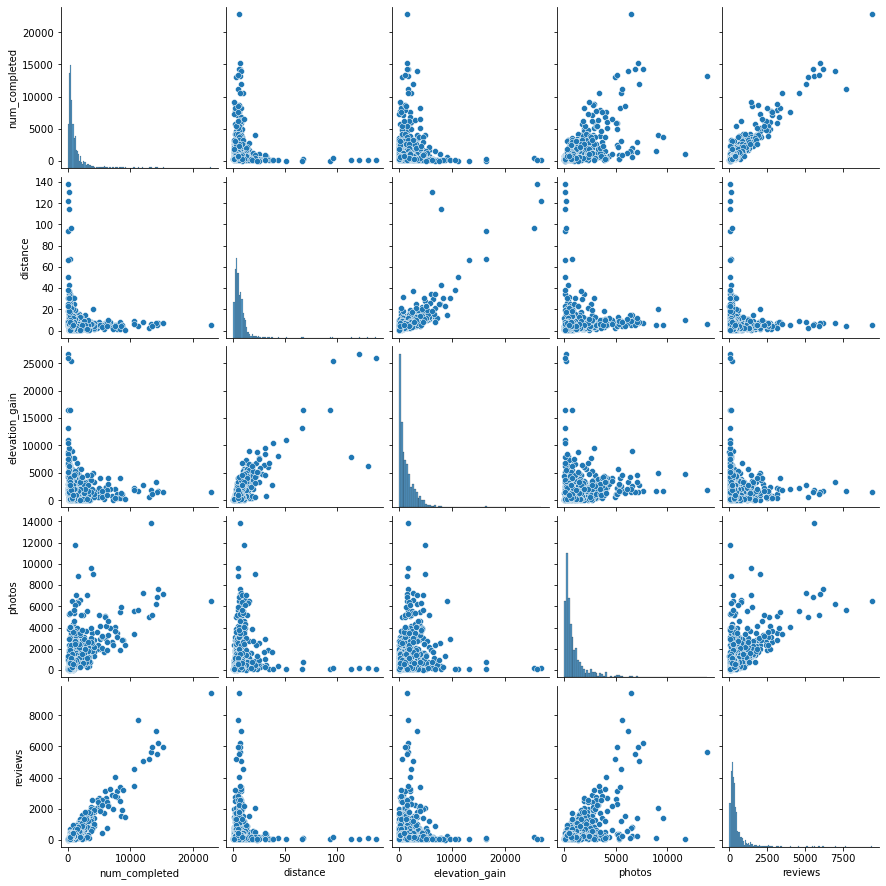

In [4]:
sns.pairplot(all_trails[['num_completed','distance','elevation_gain', 'photos','reviews']]);

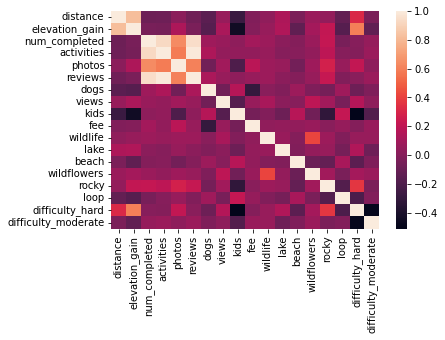

In [5]:
sns.heatmap(all_trails.corr());

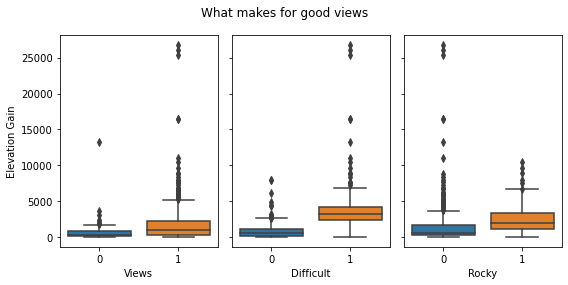

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  sharey = True)
sns.boxplot(ax = ax1, x = all_trails.views, y = all_trails.elevation_gain)
sns.boxplot(ax = ax2, x = all_trails.difficulty_hard, y = all_trails.elevation_gain)
sns.boxplot(ax = ax3, x = all_trails.rocky, y = all_trails.elevation_gain)
ax1.set_ylabel('Elevation Gain')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.set_xlabel('Views')
ax2.set_xlabel('Difficult')
ax3.set_xlabel('Rocky')
fig.set(figheight = 4, figwidth =8)
fig.suptitle('What makes for good views')
fig.tight_layout()
fig.savefig('views_visual.png');

# Select initial features and target for regression and check VIF

In [7]:
x = all_trails.drop(columns = ['trail_name','num_completed',
                               'activities', 'reviews'])
y = all_trails['num_completed']

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['variables'] = x.columns
vif['vif'] =[variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif

,variables,vif
0,distance,5.408781
1,elevation_gain,8.179881
2,photos,1.860761
3,dogs,2.524579
4,views,7.632283
5,kids,2.807141
6,fee,1.628145
7,wildlife,4.311298
8,lake,1.604523
9,beach,1.189252


There are concerning VIFs (>5) for distance, elevation_gain, and views. Let's see if standardizing our data can improve things.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                test_size = 0.2,
                                                random_state = 10)
x_stardized = x.copy()
x_train_standardized = x_train.copy()
std = StandardScaler()
std.fit(x_train_standardized.values)
x_transformed = std.transform(x_stardized.values)
x_transformed = pd.DataFrame(x_transformed, index=x.index, columns=x.columns)

In [10]:
vif_transformed = pd.DataFrame()
vif_transformed['variables'] = x_transformed.columns
vif_transformed['vif'] =[variance_inflation_factor(x_transformed.values, i) for i in range(x_transformed.shape[1])]
vif_transformed

,variables,vif
0,distance,3.789517
1,elevation_gain,5.419622
2,photos,1.193948
3,dogs,1.167492
4,views,1.087600
5,kids,2.153026
6,fee,1.165983
7,wildlife,1.225680
8,lake,1.041726
9,beach,1.077524


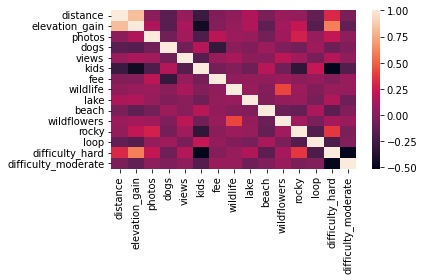

In [11]:
sns.heatmap(x_transformed.corr())
plt.tight_layout()
plt.savefig('full_correlation_matrix.png');

Distance and elevation gain are still strongly correlated so I will look to drop one of those from my model.

# Set up functions

In [12]:
def split_data(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                   test_size = 0.2,
                                                   random_state = 10)
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                   test_size = 0.25,
                                                   random_state = 2)
    return x_train, x_val, x_test, y_train, y_val, y_test

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from scipy.stats import probplot

def test_linear_regression(x_train, y_train, x_test, y_test):
    kf = KFold(n_splits = 5,
            shuffle = True,
            random_state = 10)
    
    model = LinearRegression()
    scores = cross_val_score(model, x_train, y_train, cv=kf)  
    
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    res = y_test - pred
    
    mse = metrics.mean_squared_error(y_test, pred)
    print(scores)
    print(f"{scores.mean().round(4)} accuracy with a standard deviation of {scores.std().round(4)}")
    print(f'MAE: {metrics.mean_absolute_error(y_test, pred).round(4)}')
    print(f'RMSE: {round(np.sqrt(mse), 4)}')
    
    plt.figure(figsize=(20,5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 2, 2)
    probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    

# Test linear regressions

Initial Linear Regression
[0.46389753 0.37308287 0.48435006 0.58464538 0.34145327]
0.4495 accuracy with a standard deviation of 0.0863
MAE: 695.2372
RMSE: 1078.0702


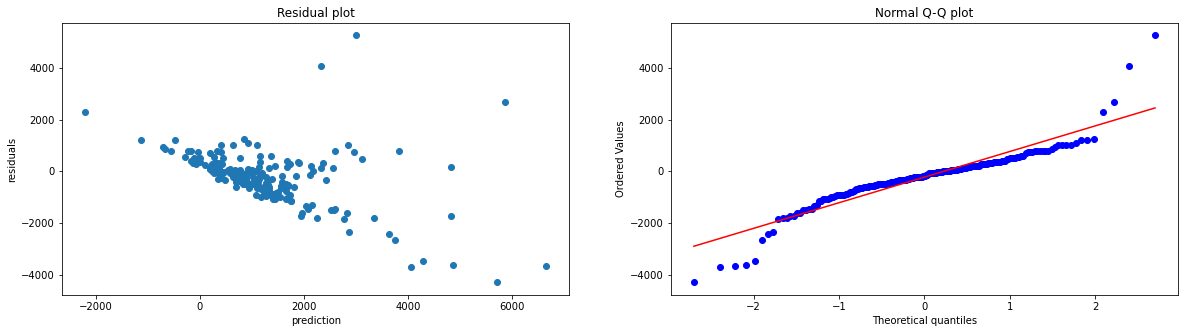

In [14]:
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x_transformed,y)
print('Initial Linear Regression')
test_linear_regression(x_train, y_train, x_val, y_val)

Looking at the plot above, the residuals appear to be correlated and are not normally distributed. The target is left skewed with a long tail. Lets try taking the log and seeing if that improves our model.

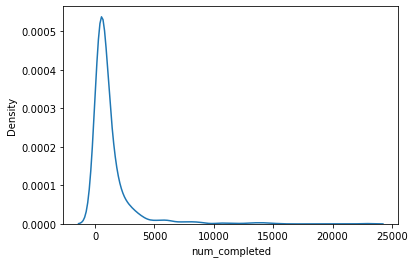

In [15]:
sns.kdeplot(y);

In [16]:
y_log = np.log(y)

Linear Regression Log Y
[0.5659804  0.38744256 0.29623642 0.47704605 0.33439604]
0.4122 accuracy with a standard deviation of 0.0979
MAE: 0.4923
RMSE: 0.6232


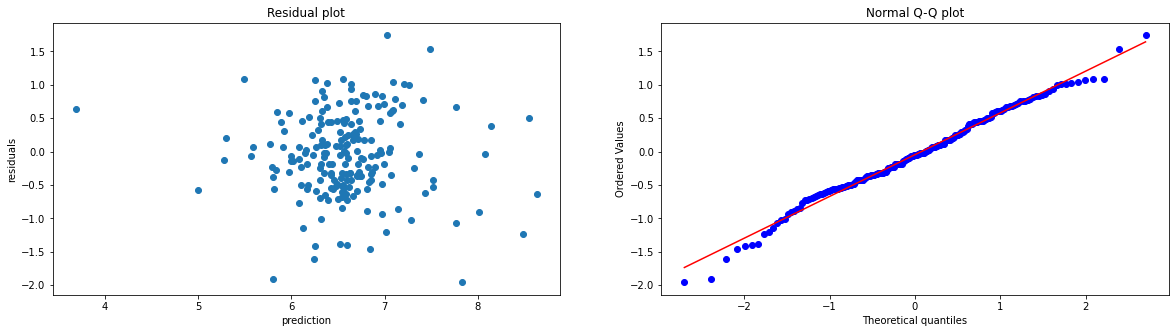

In [17]:
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x_transformed, y_log)
print('Linear Regression Log Y')
test_linear_regression(x_train, y_train, x_val, y_val)

This dropped model performance a bit, but improved the assumptions about the residuals underlying our model so we will use the transformed target going forward.

Let's see about dropping either elevation gain or distance, which we know are strongly correlated.

In [18]:
x_without_elevation = x_transformed.drop(columns = 'elevation_gain')
x_without_distance = x_transformed.drop(columns = 'distance')

Linear Regression without Elevation Gain
[0.51463784 0.40124519 0.36078899 0.45125784 0.31120799]
0.4078 accuracy with a standard deviation of 0.0705
MAE: 0.5026
RMSE: 0.6295


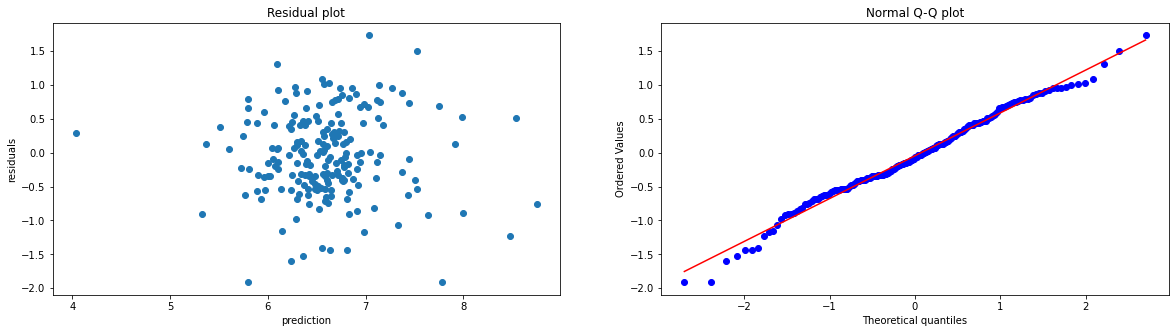

In [19]:
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x_without_elevation, y_log)
print('Linear Regression without Elevation Gain')
test_linear_regression(x_train, y_train, x_val, y_val)

Linear Regression without Distance
[0.59099899 0.38438375 0.29493688 0.4778911  0.33382756]
0.4164 accuracy with a standard deviation of 0.1066
MAE: 0.4907
RMSE: 0.6243


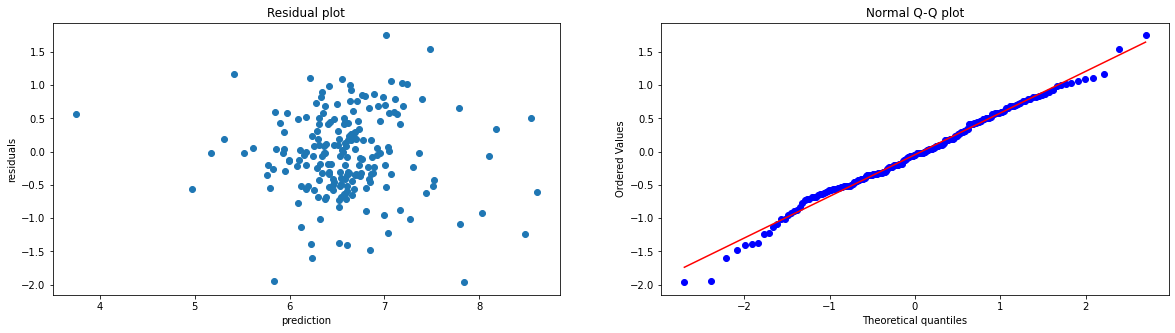

In [20]:
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x_without_distance, y_log)
print('Linear Regression without Distance')
test_linear_regression(x_train, y_train, x_val, y_val)

The model performs slightly better excluding distance as compared to excluding elevation gain so we will leave that feature out going forward. 

In [21]:
x_transformed = x_transformed.drop(columns = 'distance')
x_transformed.head()

,elevation_gain,photos,dogs,views,kids,fee,wildlife,lake,beach,wildflowers,rocky,loop,difficulty_hard,difficulty_moderate
0,-0.035782,3.964504,0.873955,0.317098,1.150076,-0.676779,0.629963,1.342948,-0.319482,0.682682,1.82179,-0.746662,-0.589395,1.192146
1,0.145936,9.324245,-1.144224,0.317098,-0.869508,1.477588,0.629963,-0.744631,-0.319482,0.682682,1.82179,1.339293,1.696656,-0.838823
2,0.096778,4.793240,0.873955,0.317098,-0.869508,-0.676779,0.629963,1.342948,-0.319482,0.682682,1.82179,-0.746662,-0.589395,1.192146
3,-0.028049,4.445375,0.873955,0.317098,-0.869508,-0.676779,0.629963,1.342948,-0.319482,0.682682,1.82179,1.339293,-0.589395,1.192146
4,0.419341,3.277545,-1.144224,0.317098,-0.869508,1.477588,0.629963,1.342948,-0.319482,0.682682,1.82179,-0.746662,1.696656,-0.838823


# Test Lasso model

In [22]:
from sklearn.linear_model import Lasso, LassoCV

def test_lasso(x_train, y_train, x_test, y_test):
    kf = KFold(n_splits = 5,
            shuffle = True,
            random_state = 10)
    
    alphas = 10**np.linspace(-2,2,1000)
    lasso_model = LassoCV(alphas = alphas, cv=kf)
    lasso_model.fit(x_train, y_train)
    lasso_best = Lasso(alpha = lasso_model.alpha_)
    scores = cross_val_score(lasso_best, x_train, y_train, cv=kf) 
    
    lasso_best.fit(x_train, y_train)
    pred = lasso_best.predict(x_test)
    res = y_test - pred
    
    mse = metrics.mean_squared_error(y_test, pred)
    print(scores)
    print(f"{scores.mean().round(4)} accuracy with a standard deviation of {scores.std().round(4)}")
    print(f'MAE: {metrics.mean_absolute_error(y_test, pred).round(4)}')
    print(f'RMSE: {round(np.sqrt(mse), 4)}')
    print(f'Alpha: {lasso_model.alpha_}')
    return lasso_best
    

In [23]:
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x_transformed, y_log)
print('Lasso Regression')
lasso_best = test_lasso(x_train, y_train, x_val, y_val)

Lasso Regression
[0.57800974 0.3888714  0.31342304 0.47864263 0.35054498]
0.4219 accuracy with a standard deviation of 0.0954
MAE: 0.487
RMSE: 0.6171
Alpha: 0.016451905877536626


In [24]:
list(zip(lasso_best.coef_, x_transformed.columns))

[(-0.28075232645457443, 'elevation_gain'),
 (0.5611196724814838, 'photos'),
 (0.1017161626783344, 'dogs'),
 (0.0410334649362788, 'views'),
 (0.09113885710618576, 'kids'),
 (-0.0, 'fee'),
 (0.01291244130607347, 'wildlife'),
 (0.007460953718633406, 'lake'),
 (0.03732696574037568, 'beach'),
 (0.0034253906724809385, 'wildflowers'),
 (0.08211370194054884, 'rocky'),
 (-0.0791056928825136, 'loop'),
 (-0.038729931937857856, 'difficulty_hard'),
 (0.0, 'difficulty_moderate')]

Looks like it took fee and difficulty moderate down to 0, so I'll drop those for future model iterations.

In [25]:
x_transformed.drop(columns = ['fee','difficulty_moderate'], inplace = True)
x_transformed.columns

Index(['elevation_gain', 'photos', 'dogs', 'views', 'kids', 'wildlife', 'lake',
       'beach', 'wildflowers', 'rocky', 'loop', 'difficulty_hard'],
      dtype='object')

# Test a Ridge regression

In [26]:
from sklearn.linear_model import Ridge, RidgeCV

def test_ridge(x_train, y_train, x_test, y_test):
    kf = KFold(n_splits = 5,
            shuffle = True,
            random_state = 10)
    
    alphas = 10**np.linspace(-2,2,1000)
    ridge_model = RidgeCV(alphas = alphas, cv=kf)
    ridge_model.fit(x_train, y_train)
    ridge_best = Ridge(alpha = ridge_model.alpha_)
    scores = cross_val_score(ridge_best, x_train, y_train, cv=kf) 
    
    ridge_best.fit(x_train, y_train)
    pred = ridge_best.predict(x_test)
    res = y_test - pred
    
    mse = metrics.mean_squared_error(y_test, pred)
    print(scores)
    print(f"{scores.mean().round(4)} accuracy with a standard deviation of {scores.std().round(4)}")
    print(f'MAE: {metrics.mean_absolute_error(y_test, pred).round(4)}')
    print(f'RMSE: {round(np.sqrt(mse), 4)}')
    print(f'Alpha: {ridge_model.alpha_}')
    return ridge_best

In [27]:
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x_transformed, y_log)
print('Ridge Regression')
ridge_best = test_ridge(x_train, y_train, x_val, y_val)

Ridge Regression
[0.5675105  0.40475321 0.32828262 0.45502272 0.39114008]
0.4293 accuracy with a standard deviation of 0.08
MAE: 0.4944
RMSE: 0.6275
Alpha: 60.7832312829723


# Test Elastic Net regression

In [28]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

def test_enet(x_train, y_train, x_test, y_test):
    kf = KFold(n_splits = 5,
            shuffle = True,
            random_state = 10)
    
    alphas = [0.0001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
    l1_rats = [.1, .5, .9, .95, .99, 1]
    enet_model = ElasticNetCV(alphas = alphas, l1_ratio=l1_rats, cv=kf)
    enet_model.fit(x_train, y_train)
    enet_best = ElasticNet(alpha = enet_model.alpha_, l1_ratio = enet_model.l1_ratio_)
    scores = cross_val_score(enet_best, x_train, y_train, cv=kf) 
    
    enet_best.fit(x_train, y_train)
    pred = enet_best.predict(x_test)
    res = y_test - pred
    
    mse = metrics.mean_squared_error(y_test, pred)
    print(scores)
    print(f"{scores.mean().round(4)} accuracy with a standard deviation of {scores.std().round(4)}")
    print(f'MAE: {metrics.mean_absolute_error(y_test, pred).round(4)}')
    print(f'RMSE: {round(np.sqrt(mse), 4)}')
    print(f'Alpha: {enet_model.alpha_}')
    print(f'L1 Ratio: {enet_model.l1_ratio_}')
    return enet_best

In [29]:
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x_transformed, y_log)
print('Elastic Net Regression')
enet_best = test_enet(x_train, y_train, x_val, y_val)

Elastic Net Regression
[0.56595769 0.40236537 0.3296787  0.46097051 0.3828678 ]
0.4284 accuracy with a standard deviation of 0.0806
MAE: 0.4923
RMSE: 0.6237
Alpha: 0.1
L1 Ratio: 0.1


The score on the elastic net regression is the best so far, so I will use that moving forward. 

# Trying different feature combinations

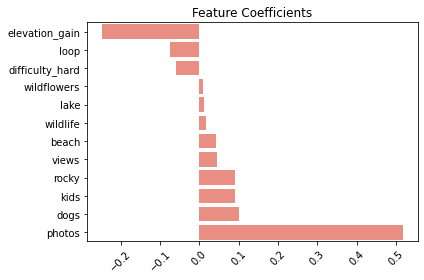

In [30]:
coefficients = list(zip(enet_best.coef_, x_transformed.columns))
coefs_df = pd.DataFrame(coefficients)
coefs_df.sort_values(0, inplace = True)
sns.barplot(x = coefs_df[0], y = coefs_df[1], color='salmon')
plt.title('Feature Coefficients')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation = 45)
plt.tight_layout();

In [31]:
list(zip(enet_best.coef_, x_transformed.columns))

[(-0.24701509821569975, 'elevation_gain'),
 (0.5166829100783681, 'photos'),
 (0.10113388168799282, 'dogs'),
 (0.043699954406594285, 'views'),
 (0.09089330393446592, 'kids'),
 (0.017199609521370816, 'wildlife'),
 (0.0129702266078998, 'lake'),
 (0.042276021674199596, 'beach'),
 (0.00863981948888626, 'wildflowers'),
 (0.09016890286665633, 'rocky'),
 (-0.07343392337463915, 'loop'),
 (-0.05850972313672206, 'difficulty_hard')]

In [32]:
x_simple = x_transformed.drop(columns = ['wildflowers','wildlife','lake'])

In [33]:
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x_simple,y_log)
print('Simplified Elastic Net Regression')
enet_simple = test_enet(x_train, y_train, x_val, y_val)

Simplified Elastic Net Regression
[0.56449955 0.40158155 0.35056581 0.46413163 0.38488177]
0.4331 accuracy with a standard deviation of 0.0753
MAE: 0.491
RMSE: 0.6219
Alpha: 0.1
L1 Ratio: 0.1


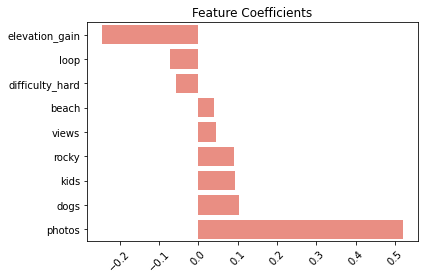

In [34]:
coefficients = list(zip(enet_simple.coef_, x_simple.columns))
coefs_df = pd.DataFrame(coefficients)
coefs_df.sort_values(0, inplace = True)
sns.barplot(x = coefs_df[0], y = coefs_df[1], color='salmon')
plt.title('Feature Coefficients')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.savefig('feature_coefficients.png');

# Retrain finalized model and test on holdout data

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x_simple, y_log,
                                                    test_size = 0.2,
                                                    random_state = 10)

In [36]:
model = ElasticNet(alpha = 0.1, l1_ratio = 0.1) 
model.fit(x_train, y_train)
pred = model.predict(x_test)
res = y_test - pred

In [37]:
print(f'Model score on training data: {model.score(x_train, y_train).round(4)}')
print(f'Model score on test data: {model.score(x_test, y_test).round(4)}')

Model score on training data: 0.4601
Model score on test data: 0.4231


In [38]:
pred_transformed = np.exp(pred)
y_test_transformed = np.exp(y_test)

In [39]:
mae = metrics.mean_absolute_error(y_test_transformed, pred_transformed)

In [40]:
print(f'Mean Absolute Error: {mae.round()}')
print(f'Median Number of Completions: {all_trails.num_completed.median()}')

Mean Absolute Error: 928.0
Median Number of Completions: 658.0


In [41]:
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': pred})
results_df.sort_values('Predicted',ascending=False)

,Actual,Predicted
1,9.487669,11.215329
6,9.388738,8.943335
379,7.188413,8.584275
11,8.687948,8.026265
31,8.713253,7.788097
...,...,...
981,4.110874,5.504858
977,4.317488,5.445611
954,4.634729,2.654827
897,6.144186,2.639999


In [42]:
all_trails['Predicted'] = np.exp(results_df.Predicted).round()
all_trails['Resid'] = all_trails.num_completed - all_trails.Predicted

In [43]:
(all_trails.iloc[2:,:]
.sort_values('Resid',ascending=True)
.head(10)[['trail_name', 'num_completed','Predicted']]
.rename(columns = {'trail_name':'Trail Name',
                  'num_completed':'Number of Hikers',
                   'Predicted':'Predicted Number of Hikers'}))

,Trail Name,Number of Hikers,Predicted Number of Hikers
379,Wright Mountain,1324.0,5347.0
969,Muir Snowfield Ski Tour,957.0,2191.0
642,Island Lake Trail,562.0,1488.0
776,Kalaloch 4th Beach Trail,205.0,721.0
764,Observation Peak Trail,169.0,664.0
946,Mirror Lake via PCT Trail,315.0,778.0
794,Nooksack Falls Trail,338.0,788.0
847,Twin Sisters Rock,344.0,782.0
952,Barlow Point Trail,283.0,713.0
555,Old Sauk River Trail,494.0,917.0


# Test linear regression assumptions

### Collinearity

In [44]:
vif_final = pd.DataFrame()
vif_final['variables'] = x_simple.columns
vif_final['vif'] =[variance_inflation_factor(x_simple.values, i) for i in range(x_simple.shape[1])]
vif_final

,variables,vif
0,elevation_gain,1.647150
1,photos,1.137190
2,dogs,1.052315
3,views,1.045722
4,kids,1.518641
5,beach,1.050342
6,rocky,1.262083
7,loop,1.108275
8,difficulty_hard,1.896036


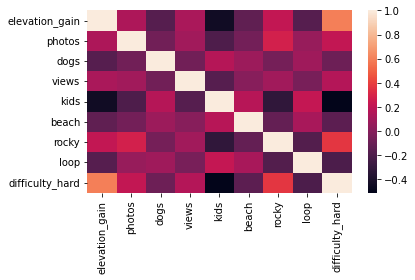

In [45]:
sns.heatmap(x_simple.corr())
plt.tight_layout()
plt.savefig('simple_correlation_matrix.png');

### Normality

Residuals should be normally distributed with a mean of zero.

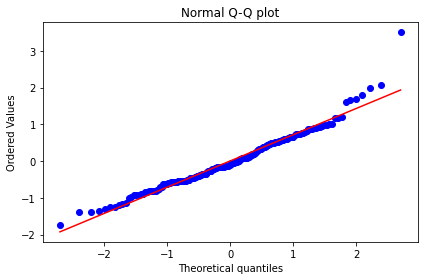

In [46]:
probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.tight_layout()
plt.savefig('QQ plot.png');

### Independence of Errors

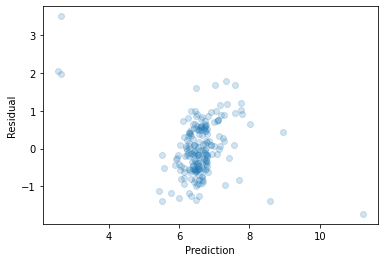

In [47]:
plt.scatter(pred, res, alpha = 0.2)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.savefig('residuals.png');